In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import pearsonr
%matplotlib inline
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_pair = pd.read_csv("../data/allPair.csv",low_memory=False)
universities = pd.read_csv("../data/university.csv")
state = 'CA'

def state_df(df, state):
    return df[df['state'] == state]

state_pair = state_df(all_pair, state)
state_univ = state_df(universities, state)

In [81]:
def home_count_to_univ(df):
    '''
    find the number of homes to the nearest university, grouped by university
    '''
    state_grouped = df.groupby('UniversityName')
    home_count = state_grouped.size()
    home_count.sort_values(inplace=True,ascending=False)
    home_count_df = pd.DataFrame({"UniversityName":home_count.index, "homeCount":home_count.values})
    return state_grouped, home_count_df

In [82]:
def distcorr_univ(pair, max_dist):
    '''
    find the saleprice-distance correlation for each university, and append it as a column in home_count_to_university
    '''
    pair = pair[pair['distance']<max_dist]
    state_grouped_by_univ, home_count_to_university = home_count_to_univ(pair)
    univNames = home_count_to_university['UniversityName'].tolist()
    home_count_to_university['distCorr'] = np.nan

    for i in range(len(univNames)):
        univ = home_count_to_university.loc[home_count_to_university.index[i], 'UniversityName']
        df = state_grouped_by_univ.get_group(univ)
        corr = df.corr()
        home_count_to_university.loc[home_count_to_university.index[i], 'distCorr'] = corr['saleprice']['distance']

    return home_count_to_university


In [83]:
def corr_all(pair, univ, dist=100):
    '''
    find the correlation between features and distcorr for each university
    '''
    distcorr_df = distcorr_univ(pair,dist)
    df = pd.merge(univ, distcorr_df, on='UniversityName', how='inner')
    features = ["acceptanceRate","ranking","enroll","acadStaff","students","underGrad","postGrad"]

    # convert object features to int, then plot it vs distCorr
    for f in features:
        dff = df[[f, 'distCorr']]
        dff.dropna(inplace=True)
#         if f == 'enroll':
#             print dff
        dff[f] = pd.to_numeric(dff[f], downcast='integer', errors='coerce')
        dff.dropna(inplace=True)
#         if f == 'enroll':
#             print dff
        dff = dff.sort_values(by=f)
        plt.figure()
        plt.scatter(dff[f], dff['distCorr'])
        plt.xlabel(f)
        plt.ylabel("distCorr")
        plt.show()
        
        corr = pearsonr(dff[f], dff['distCorr'])
        print "corr = %.4f, p = %.4f" %(corr[0], corr[1])
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


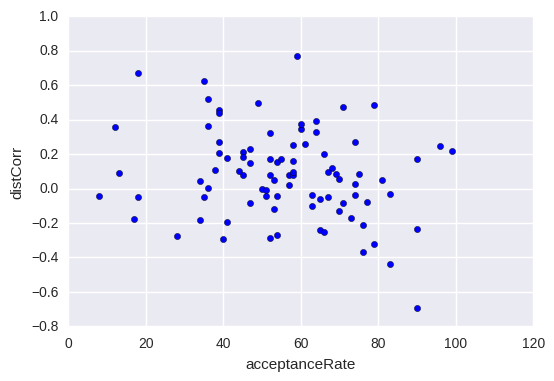

corr = -0.2130, p = 0.0476


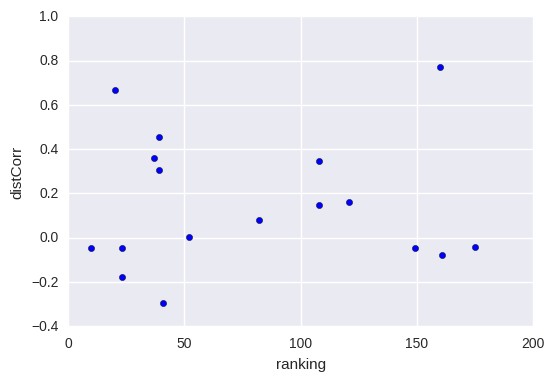

corr = 0.0399, p = 0.8792


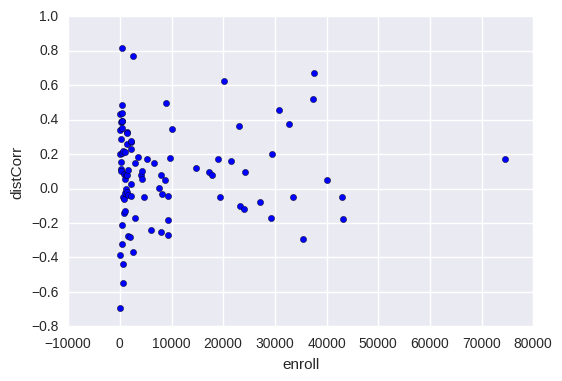

corr = 0.0585, p = 0.5775


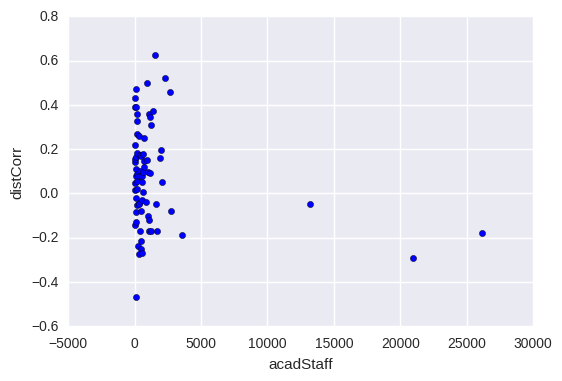

corr = -0.2228, p = 0.0531


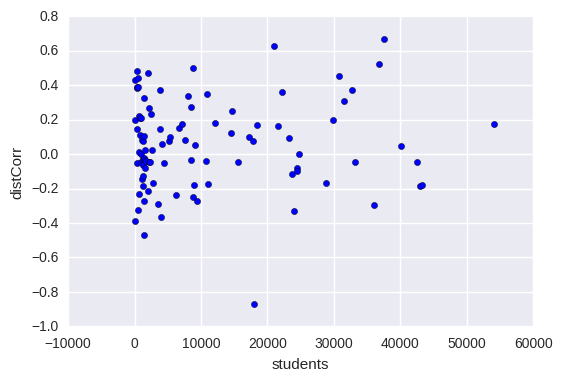

corr = 0.0585, p = 0.5691


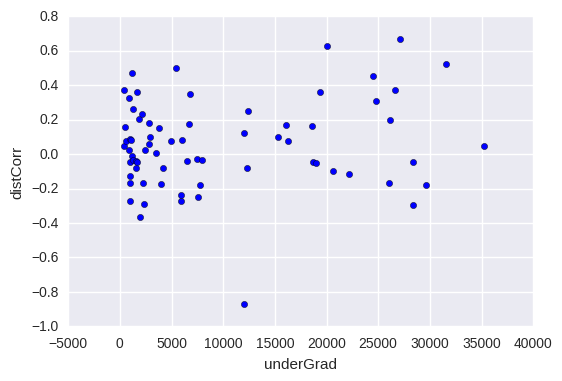

corr = 0.1610, p = 0.1830


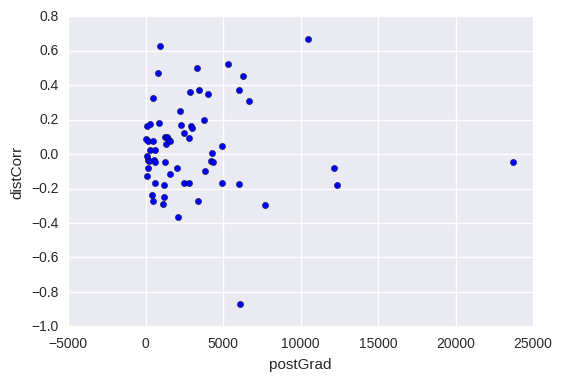

corr = 0.0086, p = 0.9461


In [84]:
corr_all(state_pair, state_univ, 10)
    

In [89]:
def feature_group(pair, features, dist):
    for feature in features:
        pair_df = pair[[feature, 'UniversityName','saleprice', 'distance']]
        pair_df = pair_df[pair_df['distance'] < dist]
        pair_df.dropna(inplace=True)
        pair_df['saleprice'] = pd.to_numeric(pair_df['saleprice'], downcast='integer', errors='coerce')
        pair_df.dropna(inplace=True)
        pair_df = pair_df[pair_df['saleprice'] > 0]
        
        # find the 3 universities with most homes paired to it
        pair_grouped = pair_df.groupby('UniversityName')
        home_count = pair_grouped.size()
        home_count.sort_values(inplace=True,ascending=False)
        home_count_top3 = home_count[:3]
        univ_names = [name for name in home_count_top3.index]
        
        # plot price vs distance for each university features
        for univ_name in univ_names:
            univ = pair_grouped.get_group(univ_name)
            one_univ_grouped = univ.groupby(feature)
            for fea in set(univ[feature]):
                univ_one_feat = one_univ_grouped.get_group(fea)
                plt.plot(univ_one_feat['distance'], univ_one_feat['saleprice'], linestyle='none', marker='o', label=fea)
                corr = pearsonr(univ_one_feat['distance'], univ_one_feat['saleprice'])
                print 'corr(price, distance) on %s = %s is %.4f, p = %.4f' %(feature, fea, corr[0], corr[1])

            plt.xlabel('distance')
            plt.ylabel('sale price')
            plt.title(univ_name + ' by ' + feature)
            plt.legend(loc='best')
            plt.show()

corr(price, distance) on record_type = sale is -0.1101, p = 0.3249


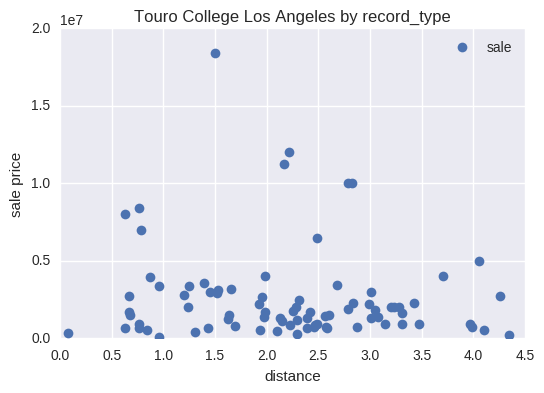

corr(price, distance) on record_type = sale is -0.1898, p = 0.0938


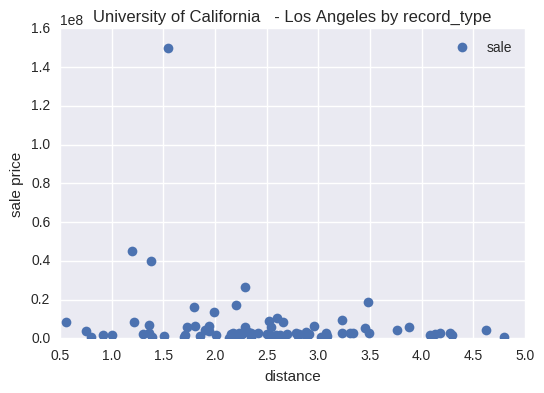

corr(price, distance) on record_type = sale is 0.0020, p = 0.9863


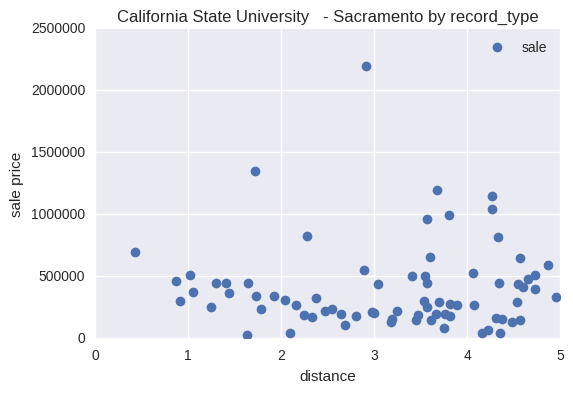

corr(price, distance) on numbed = 1 is 0.7412, p = 0.1517
corr(price, distance) on numbed = 2 is -0.0164, p = 0.9520
corr(price, distance) on numbed = 3 is -0.5336, p = 0.0127
corr(price, distance) on numbed = 4 is -0.1949, p = 0.5044
corr(price, distance) on numbed = 5 is -0.3549, p = 0.4347
corr(price, distance) on numbed = 6 is -0.4895, p = 0.2183
corr(price, distance) on numbed = 7 is nan, p = nan
corr(price, distance) on numbed = -1 is -0.1036, p = 0.7758


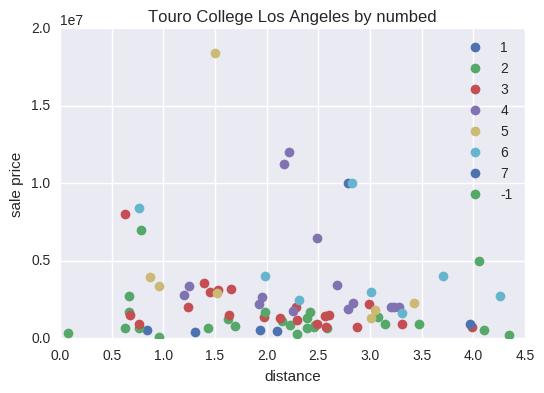

corr(price, distance) on numbed = 2 is 0.1356, p = 0.6909
corr(price, distance) on numbed = 3 is 0.0867, p = 0.7495
corr(price, distance) on numbed = 4 is -0.2424, p = 0.3657
corr(price, distance) on numbed = 5 is -0.2272, p = 0.3496
corr(price, distance) on numbed = 6 is -0.0491, p = 0.9687
corr(price, distance) on numbed = 7 is nan, p = nan
corr(price, distance) on numbed = 8 is nan, p = nan
corr(price, distance) on numbed = 10 is nan, p = nan
corr(price, distance) on numbed = -1 is -0.5113, p = 0.1079


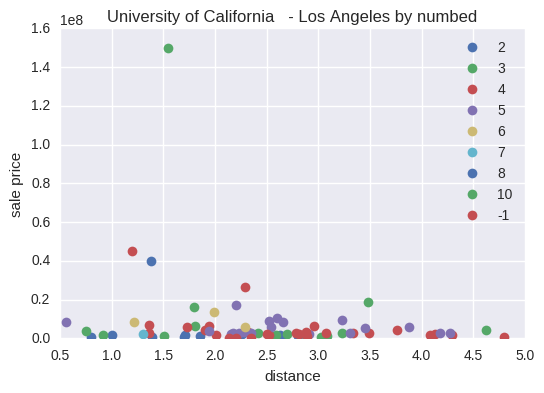

corr(price, distance) on numbed = 1 is 0.9902, p = 0.0098
corr(price, distance) on numbed = 2 is 0.3801, p = 0.1623
corr(price, distance) on numbed = 3 is 0.0011, p = 0.9949
corr(price, distance) on numbed = 4 is 0.0386, p = 0.9421
corr(price, distance) on numbed = 5 is -0.9718, p = 0.1516
corr(price, distance) on numbed = 8 is 1.0000, p = 0.0000
corr(price, distance) on numbed = -1 is -0.3847, p = 0.2427


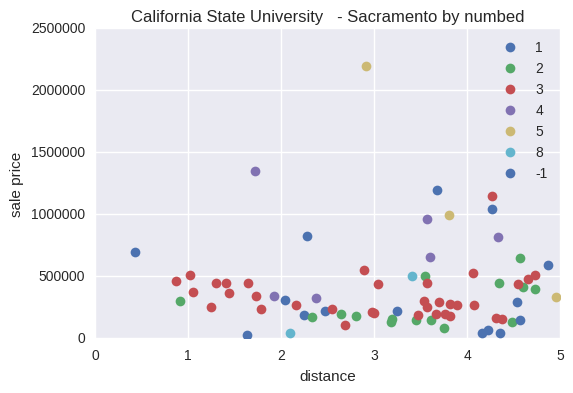

corr(price, distance) on num_bath_full = 1 is 0.9289, p = 0.0074
corr(price, distance) on num_bath_full = 2 is -0.0814, p = 0.7187
corr(price, distance) on num_bath_full = 3 is -0.1668, p = 0.5083
corr(price, distance) on num_bath_full = 4 is -0.6712, p = 0.0478
corr(price, distance) on num_bath_full = 5 is -0.3312, p = 0.3499
corr(price, distance) on num_bath_full = 6 is -0.9587, p = 0.0413
corr(price, distance) on num_bath_full = 8 is nan, p = nan
corr(price, distance) on num_bath_full = 9 is nan, p = nan
corr(price, distance) on num_bath_full = 10 is nan, p = nan
corr(price, distance) on num_bath_full = -1 is -0.2259, p = 0.5304


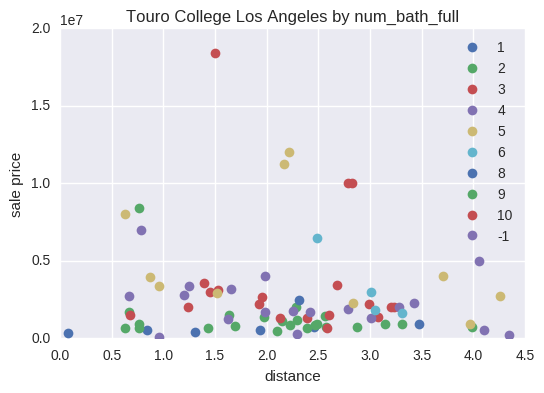

corr(price, distance) on num_bath_full = 1 is nan, p = nan
corr(price, distance) on num_bath_full = 2 is 0.5478, p = 0.0228
corr(price, distance) on num_bath_full = 3 is -0.0281, p = 0.9240
corr(price, distance) on num_bath_full = 4 is -0.0966, p = 0.7536
corr(price, distance) on num_bath_full = 5 is -0.3323, p = 0.3180
corr(price, distance) on num_bath_full = 6 is 0.7765, p = 0.1225
corr(price, distance) on num_bath_full = 7 is 1.0000, p = 0.0000
corr(price, distance) on num_bath_full = 8 is -0.2553, p = 0.7447
corr(price, distance) on num_bath_full = -1 is -0.4319, p = 0.1609


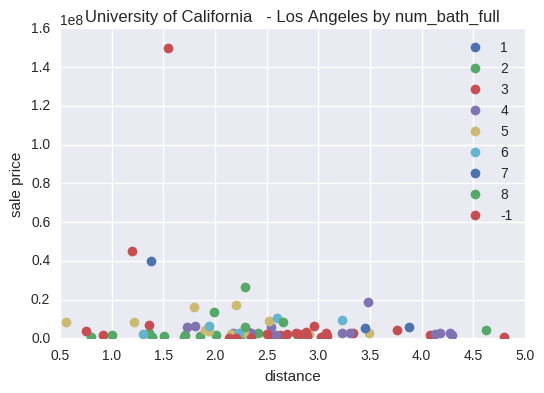

corr(price, distance) on num_bath_full = 1 is -0.1562, p = 0.4460
corr(price, distance) on num_bath_full = 2 is 0.4305, p = 0.0514
corr(price, distance) on num_bath_full = 3 is -0.0139, p = 0.9676
corr(price, distance) on num_bath_full = 4 is 1.0000, p = 0.0000
corr(price, distance) on num_bath_full = 5 is -1.0000, p = 0.0000
corr(price, distance) on num_bath_full = -1 is -0.3299, p = 0.2494


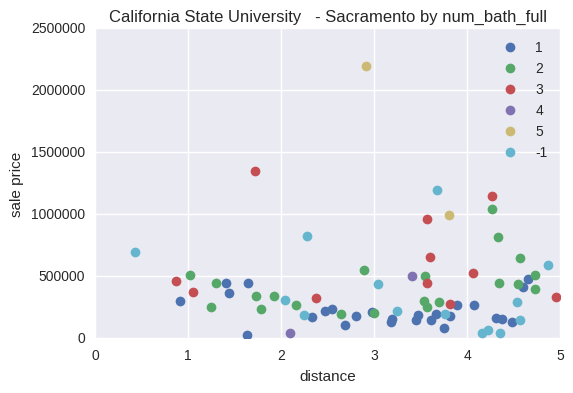

In [90]:
features = ['record_type','numbed','num_bath_full']
# features = ['numbed','num_bath_full']
feature_group(state_pair, features, 5)

## take a more careful look at the above plots

In [151]:
def feature_group_2ed(pair, features, dist):
    for feature in features:
        pair_df = pair[[feature, 'UniversityName','saleprice', 'distance']]
        pair_df = pair_df[pair_df['distance'] < dist]
        pair_df.dropna(inplace=True)
        pair_df['saleprice'] = pd.to_numeric(pair_df['saleprice'], downcast='integer', errors='coerce')
        pair_df.dropna(inplace=True)
        pair_df = pair_df[pair_df['saleprice'] > 0]

        # find the top universities with most homes paired to it
        pair_grouped = pair_df.groupby('UniversityName')
        home_count = pair_grouped.size()
        home_count.sort_values(inplace=True,ascending=False)
        home_count_top = home_count[:4]
        print home_count_top
        univ_names = [name for name in home_count_top.index]
        
        # plot price vs distance for each university features
        for univ_name in univ_names:
            univ = pair_grouped.get_group(univ_name)
            one_univ_grouped = univ.groupby(feature)
            print "%%%%%%%%%%%%%%%%%%%%%%%"
            print univ_name
            print one_univ_grouped.size()
            sigX, sigY, desc = [], [], []
            for fea in set(univ[feature]):
                univ_one_feat = one_univ_grouped.get_group(fea)
                if len(univ_one_feat) < 5 or fea == -1:
                    continue
                plt.plot(univ_one_feat['distance'], univ_one_feat['saleprice'], linestyle='none', marker='o', label=fea)
                corr = pearsonr(univ_one_feat['distance'], univ_one_feat['saleprice'])
                print 'corr(price, distance) on %s = %s is %.4f, p = %.4f' %(feature, fea, corr[0], corr[1])
                if corr[1] < 0.05:
                    sigX.append(univ_one_feat['distance'])
                    sigY.append(univ_one_feat['saleprice'])
                    desc.append(fea)

            plt.xlabel('distance')
            plt.ylabel('sale price')
            plt.title(univ_name + ' by ' + feature)
            plt.legend(loc='best')
            plt.show()
            
            if len(sigX) > 0:
                plt.figure()
                for i in range(len(sigX)):
                    plt.plot(sigX[i], sigY[i], linestyle='none', marker='o', label=desc[i])
                plt.xlabel('distance')
                plt.ylabel('sale price')
                plt.legend(loc='best')
                plt.title(univ_name + ' by ' + feature)
                plt.show()
        

UniversityName
California State University   - Sacramento     188
William Jessup University                      157
Soka University of America                     157
California State University   - Bakersfield    157
dtype: int64
%%%%%%%%%%%%%%%%%%%%%%%
California State University   - Sacramento
numbed
-1    17
 1     5
 2    34
 3    80
 4    41
 5     6
 6     2
 8     3
dtype: int64
corr(price, distance) on numbed = 1 is -0.0200, p = 0.9746
corr(price, distance) on numbed = 2 is -0.1171, p = 0.5097
corr(price, distance) on numbed = 3 is -0.1466, p = 0.1944
corr(price, distance) on numbed = 4 is -0.4285, p = 0.0052
corr(price, distance) on numbed = 5 is -0.6156, p = 0.1933


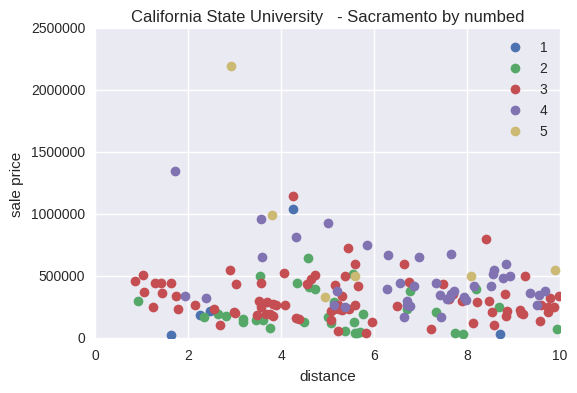

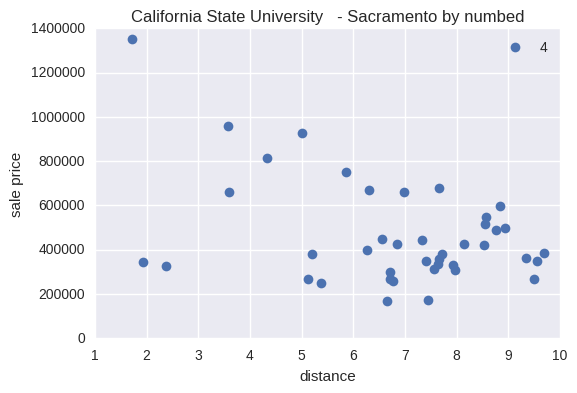

%%%%%%%%%%%%%%%%%%%%%%%
William Jessup University
numbed
-1    10
 2    18
 3    47
 4    49
 5    30
 6     3
dtype: int64
corr(price, distance) on numbed = 2 is -0.7322, p = 0.0006
corr(price, distance) on numbed = 3 is -0.2472, p = 0.0938
corr(price, distance) on numbed = 4 is 0.0818, p = 0.5766
corr(price, distance) on numbed = 5 is 0.0954, p = 0.6160


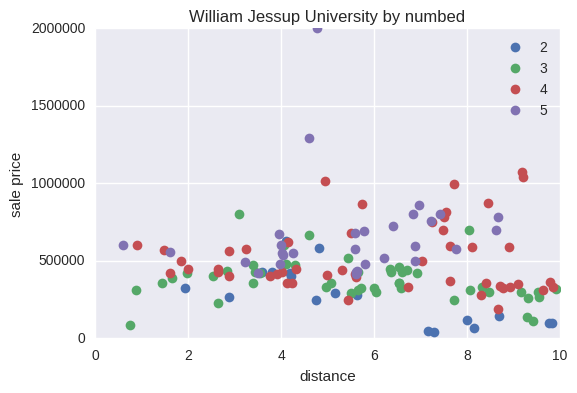

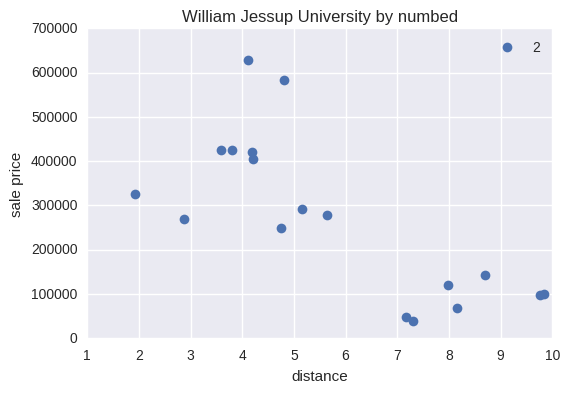

%%%%%%%%%%%%%%%%%%%%%%%
Soka University of America
numbed
-1     7
 1     3
 2    32
 3    39
 4    45
 5    27
 6     2
 7     2
dtype: int64
corr(price, distance) on numbed = 2 is 0.0883, p = 0.6309
corr(price, distance) on numbed = 3 is -0.0981, p = 0.5524
corr(price, distance) on numbed = 4 is -0.3608, p = 0.0149
corr(price, distance) on numbed = 5 is 0.1784, p = 0.3733


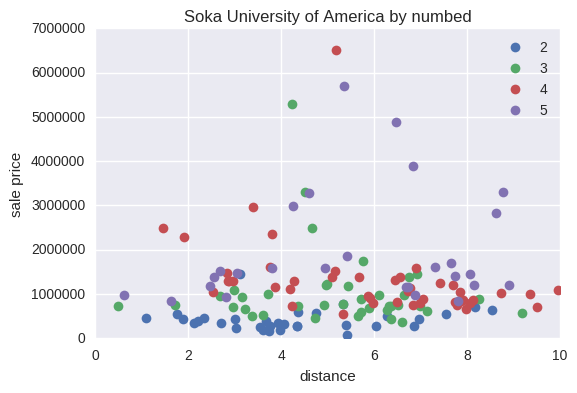

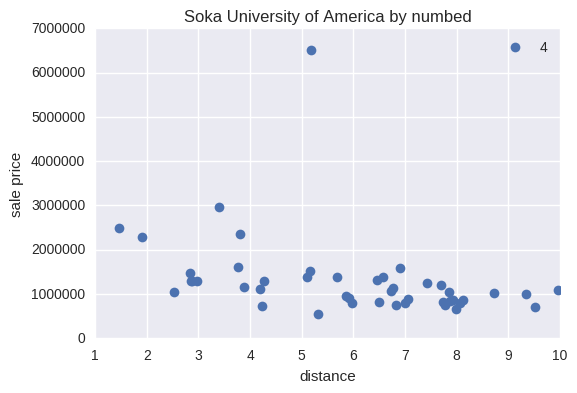

%%%%%%%%%%%%%%%%%%%%%%%
California State University   - Bakersfield
numbed
-1    14
 1     1
 2    14
 3    55
 4    63
 5     9
 6     1
dtype: int64
corr(price, distance) on numbed = 2 is -0.3721, p = 0.1901
corr(price, distance) on numbed = 3 is -0.3627, p = 0.0065
corr(price, distance) on numbed = 4 is -0.3891, p = 0.0016
corr(price, distance) on numbed = 5 is -0.1540, p = 0.6924


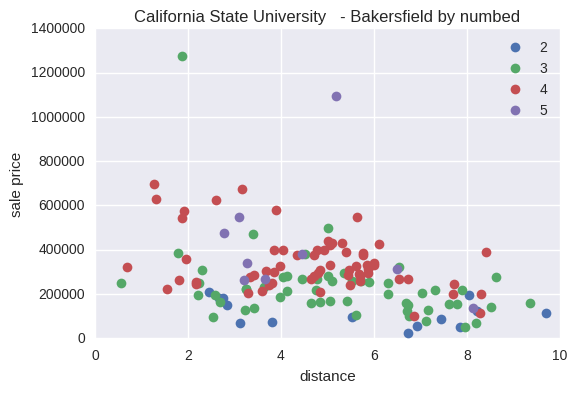

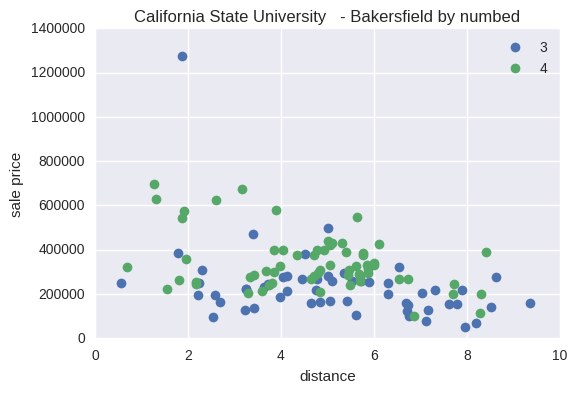

UniversityName
California State University   - Sacramento     188
William Jessup University                      157
Soka University of America                     157
California State University   - Bakersfield    157
dtype: int64
%%%%%%%%%%%%%%%%%%%%%%%
California State University   - Sacramento
num_bath_full
-1    22
 1    43
 2    77
 3    36
 4     6
 5     3
 6     1
dtype: int64
corr(price, distance) on num_bath_full = 1 is -0.2693, p = 0.0808
corr(price, distance) on num_bath_full = 2 is -0.1969, p = 0.0861
corr(price, distance) on num_bath_full = 3 is -0.2559, p = 0.1319
corr(price, distance) on num_bath_full = 4 is 0.6728, p = 0.1431


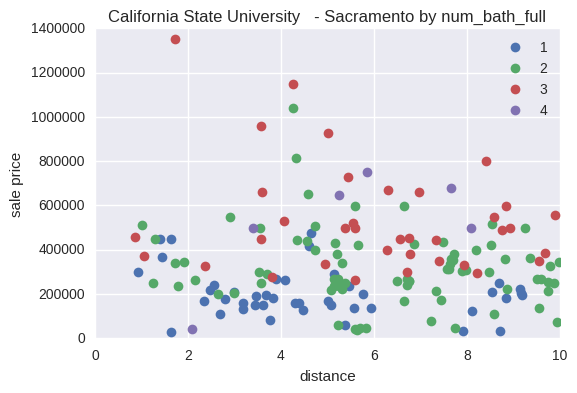

%%%%%%%%%%%%%%%%%%%%%%%
William Jessup University
num_bath_full
-1    10
 1     5
 2    68
 3    45
 4    21
 5     6
 6     1
 7     1
dtype: int64
corr(price, distance) on num_bath_full = 1 is -0.8297, p = 0.0822
corr(price, distance) on num_bath_full = 2 is -0.3542, p = 0.0030
corr(price, distance) on num_bath_full = 3 is 0.1024, p = 0.5034
corr(price, distance) on num_bath_full = 4 is 0.4725, p = 0.0305
corr(price, distance) on num_bath_full = 5 is 0.7077, p = 0.1157


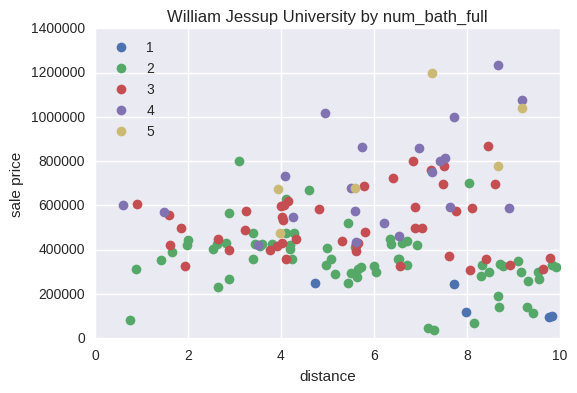

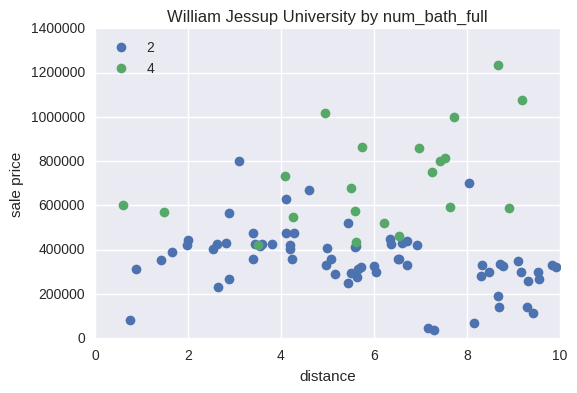

%%%%%%%%%%%%%%%%%%%%%%%
Soka University of America
num_bath_full
-1     9
 1    11
 2    54
 3    42
 4    23
 5    12
 6     3
 7     3
dtype: int64
corr(price, distance) on num_bath_full = 1 is 0.5790, p = 0.0620
corr(price, distance) on num_bath_full = 2 is 0.2061, p = 0.1350
corr(price, distance) on num_bath_full = 3 is -0.2305, p = 0.1419
corr(price, distance) on num_bath_full = 4 is -0.4097, p = 0.0522
corr(price, distance) on num_bath_full = 5 is 0.1011, p = 0.7546


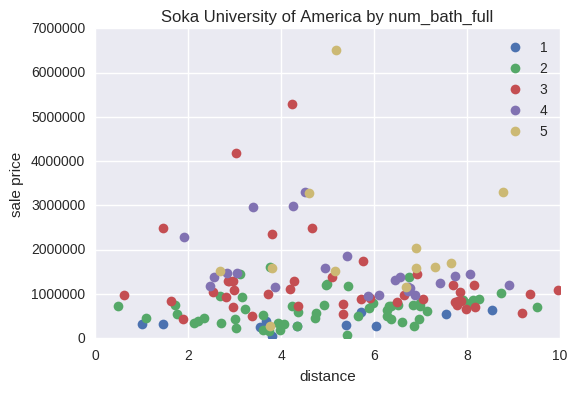

%%%%%%%%%%%%%%%%%%%%%%%
California State University   - Bakersfield
num_bath_full
-1     14
 1     22
 2     87
 3     26
 4      2
 17     2
 27     3
 47     1
dtype: int64
corr(price, distance) on num_bath_full = 1 is -0.0917, p = 0.6849
corr(price, distance) on num_bath_full = 2 is -0.3316, p = 0.0017
corr(price, distance) on num_bath_full = 3 is -0.6362, p = 0.0005


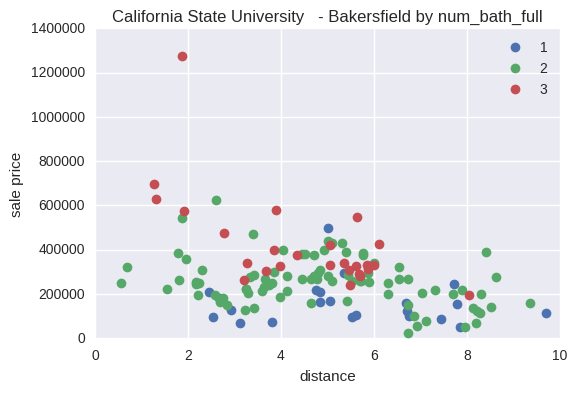

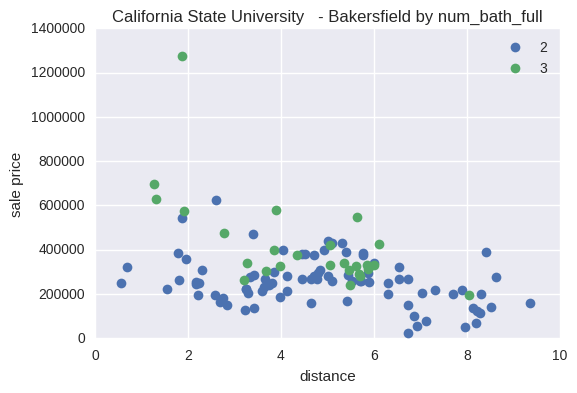

In [152]:
features = ['numbed','num_bath_full']
feature_group_2ed(state_pair, features, 10)

### 3 and 4 bedrooms home is the most popular floor plans. I will look at those homes and find out around which universities the homes have the most positive and negative distance vs price correlation.

In [17]:
def top_corr_univ(pair_df, univ_df, f_name, f_value):
    dist = 10
    univ_df['corr'] = np.nan
    univ_df['p'] = np.nan
    univ_df['num_home'] = np.nan
    
    pair_df = pair_df[['UniversityName', f_name, 'distance', 'saleprice']]
    pair_df = pair_df[pair_df['distance'] < dist]
    pair_df = pair_df[pair_df[f_name] == f_value]
    pair_df.dropna(inplace=True)
    pair_df['saleprice'] = pd.to_numeric(pair_df['saleprice'], downcast='integer', errors='coerce')
    pair_df.dropna(inplace=True)
    pair_df = pair_df[pair_df['saleprice'] > 0]
    
    pair_group = pair_df.groupby('UniversityName')
    for univ in pair_df['UniversityName'].unique():
        one_univ_df = pair_group.get_group(univ)
        if len(one_univ_df) < 10:
            continue
        corr = pearsonr(one_univ_df['distance'], one_univ_df['saleprice'])
        univ_df.at[univ_df['UniversityName'] == univ, 'corr'] = corr[0]
        univ_df.at[univ_df['UniversityName'] == univ, 'p'] = corr[1]
        univ_df.at[univ_df['UniversityName'] == univ, 'num_home'] = len(one_univ_df)
        
    return univ_df.dropna(subset=['corr', 'p'])

In [45]:
feat_convert = ['students','acadStaff','underGrad','postGrad']
for feat in feat_convert:
    state_univ[feat] = pd.to_numeric(state_univ[feat], downcast='integer', errors='coerce')
# state_univ['students'] = pd.to_numeric(state_univ['students'], downcast='integer', errors='coerce')
# state_univ['acadStaff'] = pd.to_numeric(state_univ['acadStaff'], downcast='integer', errors='coerce')
# state_univ['underGrad'] = pd.to_numeric(state_univ['underGrad'], downcast='integer', errors='coerce')
# state_univ['postGrad'] = pd.to_numeric(state_univ['postGrad'], downcast='integer', errors='coerce')

univ_3bed_df = top_corr_univ(state_pair, state_univ, 'numbed', 3)
univ_4bed_df = top_corr_univ(state_pair, state_univ, 'numbed', 4)
univ_3bath_df = top_corr_univ(state_pair, state_univ, 'num_bath_full', 3)

In [19]:
print len(state_univ), len(univ_3bed_df)

162 74


In [46]:
univ_3bed_df = univ_3bed_df.sort_values(by=['corr'])
univ_3bed_top10corr = univ_3bed_df[-10:]
univ_3bed_bottom10corr = univ_3bed_df[:10]

univ_4bed_df = univ_4bed_df.sort_values(by=['corr'])
univ_4bed_top10corr = univ_4bed_df[-10:]
univ_4bed_bottom10corr = univ_4bed_df[:10]

univ_3bath_df = univ_3bath_df.sort_values(by=['corr'])
univ_3bath_top10corr = univ_3bath_df[-10:]
univ_3bath_bottom10corr = univ_3bath_df[:10]

In [47]:
print univ_3bed_top10corr
print univ_3bed_top10corr.describe()

                                        UniversityName  \
978                                      Mills College   
380                         Columbia College Hollywood   
1557                  Trident University International   
230    California State University   - Dominguez Hills   
1373                            Santa Clara University   
291   Charles R. Drew University of Medicine & Science   
1042                         Naval Postgraduate School   
89                                  Ashford University   
331                     Cogswell Polytechnical College   
1178                       Pardee RAND Graduate School   

                     streetaddr          city state postcode acceptanceRate  \
978         5000 MacArthur Blvd       Oakland    CA    94613             57   
380             18618 Oxnard St       Tarzana    CA    91356             64   
1557         5757 Plaza Dr #100       Cypress    CA    90630             \N   
230          1000 E Victoria St        Carson

In [48]:
print univ_3bed_bottom10corr
print univ_3bed_bottom10corr.describe()

                                       UniversityName  \
467         Dominican School of Philosophy & Theology   
1620               University of California   - Davis   
226   California State Polytechnic University, Pomona   
455                       DeVry University�Long Beach   
1071               NewSchool of Architecture & Design   
164                                  Biola University   
1549                        Touro College Los Angeles   
541                      Fielding Graduate University   
41                            American Film Institute   
241        California State University   - Stanislaus   

                        streetaddr           city state postcode  \
467                   2301 Vine St       Berkeley    CA    94708   
1620                 1 Shields Ave          Davis    CA    95616   
226              3801 W Temple Ave         Pomona    CA    91768   
455        3880 Kilroy Airport Way     Long Beach    CA    90806   
1071                     1249 F 

In [49]:
print univ_4bed_top10corr
print univ_4bed_top10corr.describe()

                           UniversityName                  streetaddr  \
899        Marshall B. Ketchum University       2575 Yorba Linda Blvd   
1323                Saint John's Seminary            5012 Seminary Rd   
1812               University of the West       1409 Walnut Grove Ave   
1806            University of the Pacific            3601 Pacific Ave   
1365          San Diego Christian College  92071,  200 Riverview Pkwy   
1622  University of California   - Irvine                          \N   
1940      Westminster Seminary California       1725 Bear Valley Pkwy   
1371           San Joaquin College of Law                  901 5th St   
1373               Santa Clara University          500 El Camino Real   
380            Columbia College Hollywood             18618 Oxnard St   

             city state postcode acceptanceRate ranking enroll   latitude  \
899     Fullerton    CA    92831             \N      \N     \N  33.889793   
1323    Camarillo    CA    93012          

In [50]:
print univ_4bed_bottom10corr
print univ_4bed_bottom10corr.describe()

                                   UniversityName               streetaddr  \
455                   DeVry University�Long Beach  3880 Kilroy Airport Way   
41                        American Film Institute       2021 N Western Ave   
1977                          Woodbury University     7500 N Glenoaks Blvd   
1947                             Whittier College    13406 Philadelphia St   
1458                         Southwestern College        900 Otay Lakes Rd   
220            California Institute of Technology   1200 E California Blvd   
1620           University of California   - Davis            1 Shields Ave   
238    California State University   - Sacramento            6000 J Street   
227   California State University   - Bakersfield       9001 Stockdale Hwy   
1414                   Soka University of America                1 Hope St   

             city state postcode acceptanceRate ranking enroll   latitude  \
455    Long Beach    CA    90806             \N      \N     \N  

In [51]:
print univ_3bath_top10corr
print univ_3bath_top10corr.describe()

                           UniversityName                  streetaddr  \
1178          Pardee RAND Graduate School                1776 Main St   
1373               Santa Clara University          500 El Camino Real   
1365          San Diego Christian College  92071,  200 Riverview Pkwy   
1323                Saint John's Seminary            5012 Seminary Rd   
1622  University of California   - Irvine                          \N   
1406                   Simpson University        2211 College View Dr   
1184                       Peirce College           6201 Winnetka Ave   
1371           San Joaquin College of Law                  901 5th St   
380            Columbia College Hollywood             18618 Oxnard St   
899        Marshall B. Ketchum University       2575 Yorba Linda Blvd   

                city state postcode acceptanceRate ranking enroll   latitude  \
1178    Santa Monica    CA    90401             \N      \N    100  34.009616   
1373     Santa Clara    CA    95053 

In [52]:
print univ_3bath_bottom10corr
print univ_3bath_bottom10corr.describe()

                                       UniversityName  \
1620               University of California   - Davis   
227       California State University   - Bakersfield   
226   California State Polytechnic University, Pomona   
220                California Institute of Technology   
541                      Fielding Graduate University   
105                          Azusa Pacific University   
1215                            Pepperdine University   
1415                          Sonoma State University   
238        California State University   - Sacramento   
187                               Brandman University   

                   streetaddr           city state postcode acceptanceRate  \
1620            1 Shields Ave          Davis    CA    95616             40   
227        9001 Stockdale Hwy    Bakersfield    CA    93311             66   
226         3801 W Temple Ave         Pomona    CA    91768             53   
220    1200 E California Blvd       Pasadena    CA    91125 

(-0.24712119195105942, 0.11930839342762732)
(-0.24011724067755222, 0.17135874941027648)
(-0.24059241555812386, 0.17742820922291835)


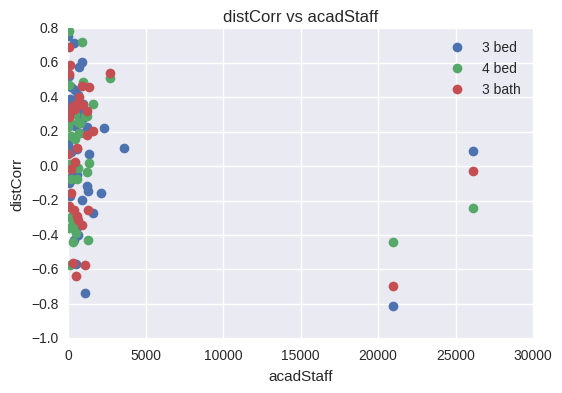

(-0.078464706610444121, 0.59202680897745319)
(-0.1086655060217622, 0.52813500374155453)
(-0.13906819871031831, 0.4050173260921599)


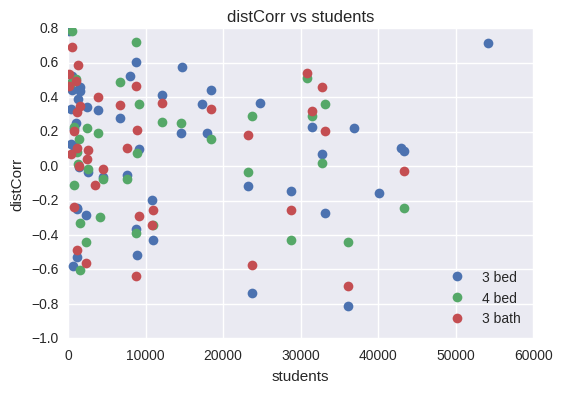

(-0.15747877664908649, 0.35192886099569631)
(0.12013783191447584, 0.52715266560252516)
(-0.0098128589027203453, 0.96047424692095051)


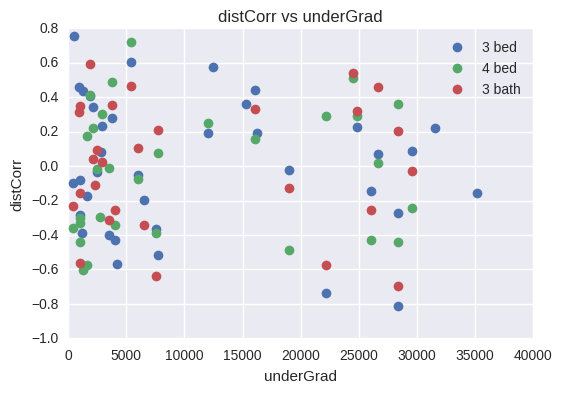

(-0.12095727106924666, 0.49560356454615151)
(0.12134675842484476, 0.54655191297883332)
(-0.017676671865312289, 0.93169913617969502)


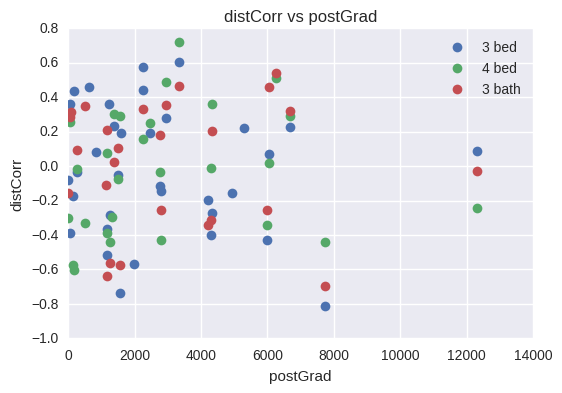

In [65]:
features = ['acadStaff', 'students', 'underGrad', 'postGrad']
group_names = ['3 bed', '4 bed', '3 bath']
for fea in features:
    for i, df in enumerate([univ_3bed_df, univ_4bed_df, univ_3bath_df]):
        df = df[[fea, 'corr']]
        df.dropna(inplace=True)
        print pearsonr(df[fea], df['corr'])
        plt.plot(df[fea], df['corr'], linestyle='none', marker='o', label=group_names[i])

    plt.xlabel(fea)
    plt.ylabel('distCorr')
    plt.title('distCorr vs ' + fea)
    plt.legend(loc='best')
    plt.show()